In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from scipy.stats import pointbiserialr
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lending-club-20072020q1/Loan_status_2007-2020Q3.gzip
/kaggle/input/lending-club-20072020q1/LCDataDictionary.xlsx


In [2]:
df = pd.read_csv("/kaggle/input/lending-club-20072020q1/Loan_status_2007-2020Q3.gzip",low_memory=False)
metadata = pd.read_excel('/kaggle/input/lending-club-20072020q1/LCDataDictionary.xlsx')

In [3]:
###EDA###

In [3]:
#removing some columns with information after the loan is given
cols_to_drop = ["Unnamed: 0","id","emp_title","title","addr_state",'out_prncp_inv','out_prncp',"total_pymnt","total_pymnt_inv","total_rec_prncp","total_rec_int","total_rec_late_fee","recoveries","collection_recovery_fee","last_pymnt_d","last_pymnt_amnt","next_pymnt_d","last_credit_pull_d","collections_12_mths_ex_med","mths_since_last_major_derog","debt_settlement_flag"]

In [4]:
metadata[metadata['LoanStatNew'].isin(cols_to_drop)]

,LoanStatNew,Description
2,addr_state,The state provided by the borrower in the loan...
11,collection_recovery_fee,post charge off collection fee
12,collections_12_mths_ex_med,Number of collections in 12 months excluding m...
20,emp_title,The job title supplied by the Borrower when ap...
27,id,A unique LC assigned ID for the loan listing.
36,last_credit_pull_d,The most recent month LC pulled credit for thi...
39,last_pymnt_amnt,Last total payment amount received
40,last_pymnt_d,Last month payment was received
51,mths_since_last_major_derog,Months since most recent 90-day or worse rating
58,next_pymnt_d,Next scheduled payment date


In [5]:
#is is unique
#addrs_state can be included as a categorical column
#employment of the debitor
#title is similar to purpose
df.drop(labels=cols_to_drop, axis=1, inplace=True, errors = 'ignore')

In [6]:
#selecting default vs normal loans
mapping = {
    "Fully Paid" : 0,
    "Current" : np.nan,
    "Charged Off" : 1,
    "Late (31-120 days)" : np.nan,
    "In Grace Period" : np.nan,
    "Late (16-30 days)" : np.nan,
    "Issued" : np.nan,
    "Does not meet the credit policy. Status:Fully Paid" : np.nan,
    "Does not meet the credit policy. Status:Charged Off" : np.nan,
    "Default" : 1
}


def encoding_target(x):
    if isinstance(x,str):
        return mapping[x]
    return np.nan
df['loan_status'] = df['loan_status'].map(encoding_target)

In [7]:
#dropping the rows not related to classification
df.dropna(subset="loan_status", axis="index", inplace=True)

In [8]:
#converting interest rate and zip code to numerical 
def converting_percentage_to_num(x):
    if not isinstance(x,str):
        return x  
    return float(x.split("%")[0].lstrip())
def filter_zip_code(x):
    if not isinstance(x,str):
        return x
    return int(x[0:-2])


# Filtering the zip code
df["zip_code"] = df["zip_code"].map(filter_zip_code)
df['int_rate'] = df['int_rate'].map(converting_percentage_to_num)
df['revol_util'] = df['revol_util'].map(converting_percentage_to_num)

In [9]:
#taking the year from the features
date_features = ["issue_d", "earliest_cr_line", "sec_app_earliest_cr_line", "hardship_start_date","hardship_end_date", "payment_plan_start_date"]

def date_transformer(x):
    if not isinstance(x,str):
        return np.nan
    date = x.split('-')
    return int(date[1])


for name in date_features:
    df[name] = df[name].map(date_transformer)


In [10]:
#converting term of the loan to numerical
def converting_term_to_num(x):
    if not isinstance(x,str):
        return np.nan
    x = x.split(" ")[1].lstrip()
    return float(x)

df["term"] = df["term"].map(converting_term_to_num)

In [11]:
def converting_employment_to_years(x):
    if not isinstance(x,str):
        return np.nan
    elif x=="10+ years":
        return 10.0
    elif x == "< 1 year":
        return 0.0
    else:
        x = x.split(" ")[0].lstrip()
    return float(x)
df["emp_length"]=df["emp_length"].map(converting_employment_to_years)

In [12]:
def converting_VS_to_years(x):
    if not isinstance(x,str):
        return np.nan
    elif x=="Not Verified":
        return 0.0
    else:
        return 1.0
df["verification_status"]=df["verification_status"].map(converting_VS_to_years)

In [13]:
##finding missing values and duplicates
number_of_missing_values = {}
percentage_of_missing_values = {}
number_of_duplicate_elements = {}
ratio_of_duplicates = {}

columns_name_to_check = df.columns
columns_name_to_check = columns_name_to_check.drop("loan_status")

for name in columns_name_to_check:
    number_of_nulls = df[name].isnull().sum()
    number_of_missing_values[name] = number_of_nulls
    percentage_of_missing_values[name] = (number_of_nulls/len(df[name]))*100
    
for name in columns_name_to_check:
    number_of_duplicate_elements[name] = (df[name].count() - df[name].nunique())

for name in columns_name_to_check:
    ratio_of_duplicates[name] = number_of_duplicate_elements[name]/df[name].count()    

reassemble_data = {
                  "Attribute Names" : list(ratio_of_duplicates.keys()),
                  "Number of Missing Values" : list(number_of_missing_values.values()),
                  "Missing Values %" : list(percentage_of_missing_values.values()),
                  "Number of Duplicates" : list(number_of_duplicate_elements.values()),
                  "Ratio of Duplicates" : list(ratio_of_duplicates.values())
                  }

statistics_about_data =  pd.DataFrame(reassemble_data)

# Visualizing the Data
statistics_sorted = statistics_about_data.sort_values(by = 'Missing Values %') 
statistics_sorted.style.set_properties(subset=['Attribute Names'], **{'font-weight': 'bold'})\
.background_gradient(axis=0) #subset='Number of Duplicates')

,Attribute Names,Number of Missing Values,Missing Values %,Number of Duplicates,Ratio of Duplicates
0,loan_amnt,0,0.000000,1859196,0.999157
61,delinq_amnt,0,0.000000,1858371,0.998714
38,acc_now_delinq,0,0.000000,1860756,0.999996
34,application_type,0,0.000000,1860762,0.999999
32,last_fico_range_low,0,0.000000,1860693,0.999962
31,last_fico_range_high,0,0.000000,1860692,0.999961
30,initial_list_status,0,0.000000,1860762,0.999999
29,total_acc,0,0.000000,1860615,0.999920
27,revol_bal,0,0.000000,1766468,0.949324
26,pub_rec,0,0.000000,1860722,0.999977


In [14]:
#removing features with all distinct values and same value in all records
unique_key_attributes = [statistics_sorted.loc[(statistics_sorted["Ratio of Duplicates"] == 0.0)]["Attribute Names"]]
features_to_delete = []

for name in unique_key_attributes:
    features_to_delete.append(unique_key_attributes[0].iloc[0])
print(f"List of features with unique value : {features_to_delete}")

for i in df.columns:
    if len(df[i].value_counts()) == 1:
        features_to_delete.append(i)

print(f"List of features that need to be deleted: {features_to_delete}")

for name in features_to_delete:
    df.drop(labels=name,axis=1,inplace=True,errors = 'ignore')
    statistics_sorted.drop(labels=name,axis=1,inplace=True,errors = 'ignore')


List of features with unique value : ['url']
List of features that need to be deleted: ['url', 'pymnt_plan', 'policy_code']


In [15]:
#removing the features with missing values greater than threshold
missing_threshold = 90
features_to_delete = list(statistics_sorted.loc[(statistics_sorted["Missing Values %"] > missing_threshold)]["Attribute Names"])

print(f"List of features that need to be deleted for missing values greater than threshold {features_to_delete}")
for  name in features_to_delete:
    df.drop(labels=name, axis=1, inplace=True,errors = 'ignore')


List of features that need to be deleted for missing values greater than threshold ['annual_inc_joint', 'dti_joint', 'verification_status_joint', 'sec_app_collections_12_mths_ex_med', 'sec_app_chargeoff_within_12_mths', 'sec_app_num_rev_accts', 'sec_app_open_act_il', 'sec_app_open_acc', 'sec_app_fico_range_low', 'sec_app_inq_last_6mths', 'sec_app_earliest_cr_line', 'sec_app_fico_range_high', 'sec_app_mort_acc', 'revol_bal_joint', 'sec_app_revol_util', 'hardship_amount', 'hardship_last_payment_amount', 'hardship_payoff_balance_amount', 'orig_projected_additional_accrued_interest', 'hardship_reason', 'hardship_status', 'hardship_type', 'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date', 'hardship_length', 'hardship_dpd', 'deferral_term', 'hardship_loan_status']


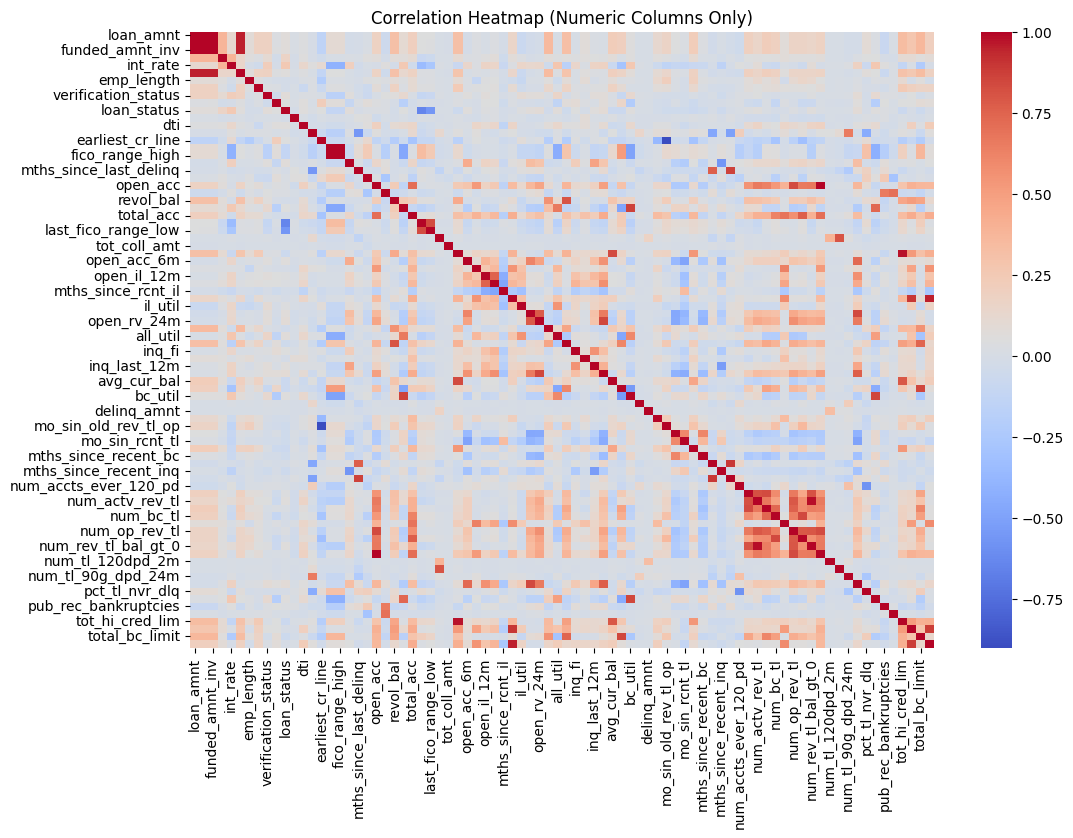

In [16]:
#removing highly correlated columns
numeric_columns = df.select_dtypes(include=['number'])

correlation_matrix = numeric_columns.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", fmt=".2f")

plt.title("Correlation Heatmap (Numeric Columns Only)")
plt.show()


(84, 84)

In [17]:
def correlationPairs(corr, threshold):
    corr_pairs = correlation_matrix.unstack()
    filtered_pairs = corr_pairs[(corr_pairs > threshold) & (corr_pairs < 1.0)]
    filtered_pairs = filtered_pairs.reset_index()
    filtered_pairs.columns = ['Column1', 'Column2', 'Correlation']
    filtered_pairs = filtered_pairs.sort_values(by='Correlation', ascending=False)
    return filtered_pairs

In [18]:
correlated_columns =  correlationPairs(correlation_matrix, threshold = 0.9)

In [19]:
correlated_columns

,Column1,Column2,Correlation
12,fico_range_low,fico_range_high,1.000000
13,fico_range_high,fico_range_low,1.000000
3,funded_amnt,loan_amnt,0.999700
0,loan_amnt,funded_amnt,0.999700
4,funded_amnt,funded_amnt_inv,0.999380
7,funded_amnt_inv,funded_amnt,0.999380
1,loan_amnt,funded_amnt_inv,0.999019
6,funded_amnt_inv,loan_amnt,0.999019
20,num_sats,open_acc,0.998878
14,open_acc,num_sats,0.998878


In [20]:
#removing the highly correlated column with more missing values
def remove_correlation_pairs(correlated_columns,statistics):
    features_to_remove = []
    sets = []
    
    for index, row in correlated_columns.iterrows():
        col1 = row['Column1']
        col2 = row['Column2']
        
        set_current = {col1,col2}        
        flag = 0
        for i in range(len(sets)):
            set_=sets[i]
            if (col1 in set_ or col2 in set_):
                set_ = set_ | set_current
                flag = 1
                sets[i]=set_
        if flag == 0:
            sets.append(set_current)
    print(sets)
    
    for set_ in sets:
        min_value = -1
        for col in set_:
            missingvalues_column = (statistics_sorted[statistics_sorted["Attribute Names"]  == col]["Number of Missing Values"]).item()
            if min_value ==-1 or missingvalues_column<min_value:
                keep_col = col
        set_.remove(keep_col)
        features_to_remove.extend(set_)
    return features_to_remove

In [21]:
features_to_remove = remove_correlation_pairs(correlated_columns,statistics_sorted)

[{'fico_range_low', 'fico_range_high'}, {'funded_amnt', 'loan_amnt', 'installment', 'funded_amnt_inv'}, {'num_sats', 'open_acc'}, {'num_rev_tl_bal_gt_0', 'num_actv_rev_tl'}, {'tot_hi_cred_lim', 'tot_cur_bal'}, {'total_bal_ex_mort', 'total_il_high_credit_limit', 'total_bal_il'}]


In [22]:
features_to_remove

['fico_range_low',
 'funded_amnt',
 'loan_amnt',
 'installment',
 'num_sats',
 'num_rev_tl_bal_gt_0',
 'tot_hi_cred_lim',
 'total_bal_ex_mort',
 'total_il_high_credit_limit']

In [23]:
###manually put the columns which you want to keep
###features_to_remove.remove("loan_amnt")

In [24]:
for name in features_to_remove:
    df.drop(labels=name, axis=1, inplace=True,errors = 'ignore')

In [25]:
df.shape

(1860764, 80)

In [26]:
#converting the remaining categorical columns to numerical using factorize
categorical_cols = df.select_dtypes(include='object').columns
print("The remaining categorical columns are ",categorical_cols)
for col in categorical_cols:
    df[col]=pd.factorize(df[col])[0]

The remaining categorical columns are  Index(['grade', 'sub_grade', 'home_ownership', 'purpose',
       'initial_list_status', 'application_type', 'hardship_flag'],
      dtype='object')


In [27]:
#correlation with target
correlation_with_target = {
    "Feature" : [],
    "Point_Biserialr_Correlation" : [],
    "Pvalue" : []
}

numerical_features = df.select_dtypes(include='float64').columns

for name in list(numerical_features): 
    if name=="loan_status":
        continue
    mini_dataset = df[[name,'loan_status']].dropna(subset=[name,'loan_status'])
    result = pointbiserialr(mini_dataset['loan_status'], mini_dataset[name])
    correlation_with_target["Feature"].append(name)
    correlation_with_target["Point_Biserialr_Correlation"].append(result.statistic)
    correlation_with_target["Pvalue"].append(result.pvalue)
correlation_with_target_dataframe = pd.DataFrame(correlation_with_target)
correlation_with_target_dataframe["Point_Biserialr_Correlation"] = abs(correlation_with_target_dataframe["Point_Biserialr_Correlation"])


In [28]:
correlation_with_target_dataframe.sort_values(by='Point_Biserialr_Correlation', ascending=False).head(10)

,Feature,Point_Biserialr_Correlation,Pvalue
18,last_fico_range_high,0.647160,0.0
19,last_fico_range_low,0.561478,0.0
2,int_rate,0.253314,0.0
1,term,0.168435,0.0
9,fico_range_high,0.120500,0.0
38,acc_open_past_24mths,0.094272,0.0
31,open_rv_24m,0.084123,0.0
64,num_tl_op_past_12m,0.081113,0.0
5,verification_status,0.074839,0.0
40,bc_open_to_buy,0.074309,0.0


In [30]:
point_biserialr_threshold = 0.9
features_to_remove = list(correlation_with_target_dataframe[correlation_with_target_dataframe["Point_Biserialr_Correlation"]>point_biserialr_threshold]["Feature"])
for name in features_to_remove:
    df.drop(labels=name, axis=1, inplace=True,errors = 'ignore')

In [31]:
#handling missing values

In [32]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 1860764 entries, 0 to 2925492
Data columns (total 80 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   funded_amnt_inv                 1860764 non-null  float64
 1   term                            1860764 non-null  float64
 2   int_rate                        1860764 non-null  float64
 3   grade                           1860764 non-null  int64  
 4   sub_grade                       1860764 non-null  int64  
 5   emp_length                      1743504 non-null  float64
 6   home_ownership                  1860764 non-null  int64  
 7   annual_inc                      1860764 non-null  float64
 8   verification_status             1860764 non-null  float64
 9   issue_d                         1860764 non-null  int64  
 10  loan_status                     1860764 non-null  float64
 11  purpose                         1860764 non-null  int64  
 12  zip_c

In [33]:
#statistics_sorted.style.set_properties(subset=['Attribute Names'], **{'font-weight': 'bold'})\
#.background_gradient(axis=0) #subset='Number of Duplicates')

In [34]:
##handling missing values
##categorical/int64 columns replaced with -1 while float64 cols replaced with mean
##replacing columns with months as 0

int_cols = df.select_dtypes(include='int64').columns
df[int_cols] = df[int_cols].fillna(-1)
mths_cols = [col for col in df.columns if col.startswith('mths')]
df[mths_cols] = df[mths_cols].fillna(0)

In [35]:
float_cols = df.select_dtypes(include='float64').columns
df[float_cols] = df[float_cols].apply(lambda x: x.fillna(x.mean()))

In [36]:
print("Final data shape is ", df.shape)

Final data shape is  (1860764, 80)


In [36]:
### p-value feature selection

In [37]:
import statsmodels.api as sm

def backward_elimination_classification(x, Y, sl, columns, nRuns):
    numVars = len(x[0])
    features_to_delete = []
    for i in range(0, nRuns):
        print("Running for i", i)
        # Fit the logistic regression model using statsmodels
        logit_model = sm.Logit(Y, x).fit(disp=0)
        
        # Get the maximum p-value from the model's p-values
        maxVar = max(logit_model.pvalues).astype(float)
        
        # If the maximum p-value is greater than the significance level (sl), remove the feature
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (logit_model.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)  # Remove the feature with the highest p-value
                    features_to_delete.append(columns[j])
                    columns = np.delete(columns, j)  # Remove the corresponding column name
    logit_model.summary()  # Display the summary of the final model
    return x, columns, features_to_delete

In [ ]:
"""import statsmodels.api as sm

def backward_elimination_classification(x, Y, sl, columns, nRuns):
    numVars = len(x[0])
    features_to_delete = []
    k=0
    for i in range(0, nRuns):
        print("Running for i", i)
        # Fit the logistic regression model using statsmodels
        logit_model = sm.Logit(Y, x).fit(disp=0)
        
        # Get the maximum p-value from the model's p-values
        maxVar = max(logit_model.pvalues).astype(float)
        
        # If the maximum p-value is greater than the significance level (sl), remove the feature
        if maxVar > sl:
            for j in range(0, numVars - k):
                if (logit_model.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)  # Remove the feature with the highest p-value
                    features_to_delete.append(columns[j])
                    columns = np.delete(columns, j)  # Remove the corresponding column name
            k+=1
    logit_model.summary()  # Display the summary of the final model
    return x, columns, features_to_delete"""

In [38]:
sl = 0.05
nRuns = 20
_,_ ,features_to_delete = backward_elimination_classification(np.array(df.drop(columns=["loan_status"], axis=1)), np.array(df["loan_status"]) , sl, df.columns, nRuns)

Running for i 0


/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Running for i 1
Running for i 2
Running for i 3
Running for i 4
Running for i 5
Running for i 6
Running for i 7
Running for i 8
Running for i 9
Running for i 10
Running for i 11
Running for i 12
Running for i 13
Running for i 14
Running for i 15
Running for i 16
Running for i 17
Running for i 18
Running for i 19


In [39]:
features_to_delete

['initial_list_status',
 'num_tl_120dpd_2m',
 'mths_since_recent_bc',
 'num_tl_90g_dpd_24m',
 'tot_cur_bal',
 'num_bc_tl',
 'mort_acc',
 'inq_fi',
 'num_sats',
 'application_type',
 'acc_now_delinq',
 'avg_cur_bal',
 'chargeoff_within_12_mths',
 'inq_last_6mths',
 'bc_open_to_buy',
 'num_accts_ever_120_pd',
 'acc_open_past_24mths']

In [38]:
features_to_delete = ['initial_list_status',
 'num_tl_120dpd_2m',
 'mths_since_recent_bc',
 'num_tl_90g_dpd_24m',
 'tot_cur_bal',
 'num_bc_tl',
 'mort_acc',
 'inq_fi',
 'num_sats',
 'application_type',
 'acc_now_delinq',
 'avg_cur_bal',
 'chargeoff_within_12_mths',
 'inq_last_6mths',
 'bc_open_to_buy',
 'num_accts_ever_120_pd',
 'acc_open_past_24mths']

In [39]:
for name in features_to_delete:
    df.drop(labels=name, axis=1, inplace=True,errors = 'ignore')

In [40]:
df['issue_d'].value_counts()

issue_d
2016    403104
2015    402837
2017    314368
2014    235619
2018    197178
2013    134814
2019     75405
2012     53367
2011     21721
2010     11536
2009      4716
2020      4286
2008      1562
2007       251
Name: count, dtype: int64

In [41]:
#df["fisco_diff"] = df["last_fico_range_high"]- df["fico_range_high"]
Xtrain = df[df['issue_d']!=2016]
ytrain = Xtrain['loan_status']
Xtrain = Xtrain.drop(labels=['loan_status'], axis=1)

Xtest = df[df['issue_d']==2016]
ytest = Xtest['loan_status']
Xtest = Xtest.drop(labels=['loan_status'], axis=1)

#print("Ratio of testing to total data is ", Xtest.shape[0]/df.shape[0])
#Xtrain, Xval, ytrain, yval = train_test_split(X, y, test_size=0.2, random_state=42)

#print("Number of samples in training data is ", Xtrain.shape[0])
#print("Number of samples in validation data is ", Xval.shape[0])
#print("Number of samples in testing data is ", Xtest.shape[0])

Xtrain.drop(labels='issue_d', axis=1, inplace=True,errors = 'ignore')
Xtest.drop(labels='issue_d', axis=1, inplace=True,errors = 'ignore')
#Xval.drop(labels='issue_d', axis=1, inplace=True,errors = 'ignore')
cols = list(Xtrain.columns)

In [42]:
Xtrain.shape

(1457660, 62)

In [43]:
#normalising the data
scaler = MinMaxScaler()
Xtrain = scaler.fit_transform(Xtrain)
#Xval = scaler.transform(Xval)
Xtest = scaler.transform(Xtest)

In [41]:
# data leakage analysis

In [42]:
"""from sklearn.metrics import classification_report
def dataLeakageRemoval(Xtrain, Ytrain, Xval, Yval, cols,minority_class='1.0', k=10, precisionThreshold = 0.7, recallThreshold=0.7):
    model = RandomForestClassifier(n_estimators=25, max_depth=3)
    model.fit(Xtrain, Ytrain)
    feature_importances_ = model.feature_importances_
    
    feature_leakage_df = {
    "Names" : cols,
    "Importance_" : feature_importances_
}
    feature_leakage_df = pd.DataFrame(feature_leakage_df)
    feature_leakage_df_topk = feature_leakage_df.sort_values(by = 'Importance_', axis=0, ascending=False).head(10)
    print("Features to check data leakage are " ,feature_leakage_df_topk)
    
    possible_leakage_features = list(feature_leakage_df_topk["Names"])
    features_to_remove = []
    idx_to_remove = []
    for name in possible_leakage_features:
        idx = cols.index(name)
        Xtrain_idx = (Xtrain[:, idx]).reshape(-1,1)
        Xtest_idx = (Xval[:, idx]).reshape(-1,1)
        
        checkerModel = RandomForestClassifier(n_estimators=10, max_depth=3)
        checkerModel.fit(Xtrain_idx, Ytrain)
        y_pred = checkerModel.predict(Xtest_idx)
        report = classification_report(Yval, y_pred, output_dict=True)
        
        precision = report[minority_class]['precision']
        recall = report[minority_class]['recall']
        
        print(f"Precision for feature {name} is ", precision)
        print(f"Recall for this feature {name} is ", recall)
        
        if precision>precisionThreshold or recall>recallThreshold:
            print("Removing feature ",name)
            features_to_remove.append(name)
            idx_to_remove.append(idx)
            
    return features_to_remove, idx_to_remove """

'from sklearn.metrics import classification_report\ndef dataLeakageRemoval(Xtrain, Ytrain, Xval, Yval, cols,minority_class=\'1.0\', k=10, precisionThreshold = 0.7, recallThreshold=0.7):\n    model = RandomForestClassifier(n_estimators=25, max_depth=3)\n    model.fit(Xtrain, Ytrain)\n    feature_importances_ = model.feature_importances_\n    \n    feature_leakage_df = {\n    "Names" : cols,\n    "Importance_" : feature_importances_\n}\n    feature_leakage_df = pd.DataFrame(feature_leakage_df)\n    feature_leakage_df_topk = feature_leakage_df.sort_values(by = \'Importance_\', axis=0, ascending=False).head(10)\n    print("Features to check data leakage are " ,feature_leakage_df_topk)\n    \n    possible_leakage_features = list(feature_leakage_df_topk["Names"])\n    features_to_remove = []\n    idx_to_remove = []\n    for name in possible_leakage_features:\n        idx = cols.index(name)\n        Xtrain_idx = (Xtrain[:, idx]).reshape(-1,1)\n        Xtest_idx = (Xval[:, idx]).reshape(-1,1)\

In [43]:
#features_to_remove, idx_to_remove = dataLeakageRemoval(Xtrain, ytrain, Xval, yval, cols, precisionThreshold=0.6, recallThreshold=0.6)

#Xtrain = np.delete(Xtrain, idx_to_remove, axis=1)
#Xtest = np.delete(Xtest, idx_to_remove, axis=1)
#Xval = np.delete(Xval, idx_to_remove, axis=1)

In [44]:
#print("Columns obtained from data leakage analysis is ", features_to_remove)

In [48]:
#possible_data_leakage_cols = ['last_pymnt_amnt','total_pymnt_inv','total_pymnt','total_rec_int','funded_amnt_inv','funded_amnt','collection_recovery_fee','collections_12_mths_ex_med','debt_settlement_flag']

In [49]:
#for  name in possible_data_leakage_cols:
#    df.drop(labels=name, axis=1, inplace=True,errors = 'ignore')

In [50]:
#orig_df = df.copy()

In [51]:
#df.info()

In [52]:
#df["fisco_diff"] = df["last_fico_range_high"]- df["fico_range_high"]

(1166128, 80)

In [53]:
#Linear modelling

In [58]:
def fit_logistic_model_with_tuning(model, X,y,param_grid,cv=3):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='accuracy')
    grid_search.fit(X, y)
    best_model = grid_search.best_estimator_
    print("Training accuracy on the best model is ", grid_search.best_score_)
    return best_model

In [59]:
model = LogisticRegression(random_state=42)
param_grid = {
    'C': [ 1, 10, 100],  # Inverse of regularization strength
    'penalty': ['l1','l2'],  # Regularization type
    'solver':['saga']
}

In [60]:
model = fit_logistic_model_with_tuning(model, Xtrain,ytrain,param_grid,cv=3)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

Training accuracy on the best model is  0.8951003674605951


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [62]:
test_score = model.score(Xtest, ytest)
print("Test Set Accuracy:\n", test_score)

Test Set Accuracy:
 0.9005368341668651


In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

def fine_tune_random_forest(X_train, y_train):
    rf = RandomForestClassifier(random_state=42)
    
    param_grid = {
        'n_estimators': [100],  # Number of trees
        'max_depth': [10, 20], # Maximum depth of the trees
        'min_samples_split': [2, 5], # Minimum number of samples required to split a node
        'min_samples_leaf': [1, 2, 4],   # Minimum number of samples required to be at a leaf node
    }
    
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                               cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    print(f"Best Parameters: {best_params}")
    best_rf = grid_search.best_estimator_
    return best_rf

In [ ]:
rf_model = fine_tune_random_forest(Xtrain, ytrain)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


In [ ]:
test_score = rf_model.score(Xtest, ytest)
print("Test Set Accuracy:\n", test_score)

In [67]:
feature_importance = model.coef_[0]

# Create a DataFrame to display features and their importance
importance_df = pd.DataFrame({
    'Feature': cols,
    'Importance': np.abs(feature_importance)
}).sort_values(by='Importance', ascending=False)

In [68]:
def plot_importance(model_name, sorted_features, sorted_importance_scores):
    plt.figure(figsize=(10, 6))
    plt.barh(sorted_features, sorted_importance_scores, color='skyblue')
    plt.xlabel('Importance')
    plt.title('Feature Importance '+model_name)
    plt.gca().invert_yaxis()  
    plt.show()

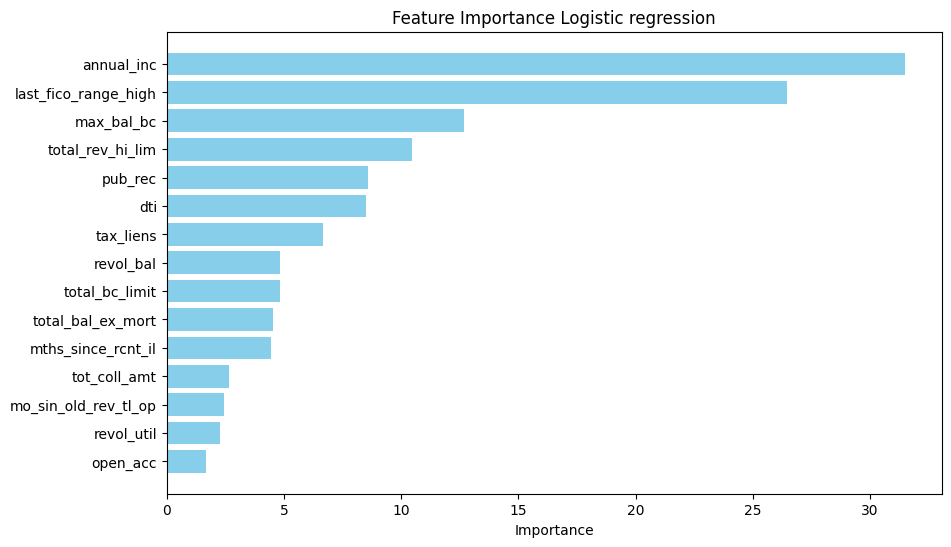

In [69]:
k =15
sorted_features = np.array(importance_df[:k]["Feature"])
sorted_importance_scores = np.array(importance_df[:k]["Importance"])
plot_importance("Logistic regression", sorted_features , sorted_importance_scores)

In [70]:
import pickle
with open('logistic_model.pkl', 'wb') as file:
    pickle.dump(model, file)


In [71]:
from sklearn.metrics import classification_report, accuracy_score, f1_score

def evaluate_model(model, X_test, y_test, major_class=0.0,minor_class=1.0):
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    
    report = classification_report(y_test, y_pred, output_dict=True)
    print(report)
    
    major_class_metrics = report[str(major_class)]
    minor_class_metrics = report[str(minor_class)]
    
    total_f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Total F1 Score (Weighted Average): {total_f1:.4f}")
    print(f"\nMajor Class ({major_class}):")
    print(f"  Precision: {major_class_metrics['precision']:.4f}")
    print(f"  Recall: {major_class_metrics['recall']:.4f}")
    print(f"  F1-Score: {major_class_metrics['f1-score']:.4f}")
    
    print(f"\nMinor Class ({minor_class}):")
    print(f"  Precision: {minor_class_metrics['precision']:.4f}")
    print(f"  Recall: {minor_class_metrics['recall']:.4f}")
    print(f"  F1-Score: {minor_class_metrics['f1-score']:.4f}")
    

In [72]:
evaluate_model(model, Xtest, ytest)

{'0.0': {'precision': 0.9350053623410449, 'recall': 0.9417230928764097, 'f1-score': 0.9383522045844532, 'support': 324022}, '1.0': {'precision': 0.7539802485863929, 'recall': 0.7317847297741584, 'f1-score': 0.7427167021740804, 'support': 79082}, 'accuracy': 0.9005368341668651, 'macro avg': {'precision': 0.8444928054637189, 'recall': 0.836753911325284, 'f1-score': 0.8405344533792668, 'support': 403104}, 'weighted avg': {'precision': 0.8994913807235334, 'recall': 0.9005368341668651, 'f1-score': 0.8999719185996525, 'support': 403104}}
Accuracy: 0.9005
Total F1 Score (Weighted Average): 0.9000

Major Class (0.0):
  Precision: 0.9350
  Recall: 0.9417
  F1-Score: 0.9384

Minor Class (1.0):
  Precision: 0.7540
  Recall: 0.7318
  F1-Score: 0.7427


In [55]:
#model = LogisticRegression(random_state=42, C=1000, penalty='l1', solver = 'saga')
#model.fit(Xtrain, ytrain)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=1000, penalty='l1', random_state=42, solver='saga')

In [70]:
"""def plot_distribution(feature, df):
    df.groupby("loan_status")[feature].hist(bins=30)
    plt.legend(["Fully Paid","Default"])
    plt.title(f"Distribution of {feature} by target", size=15)
    plt.show()"""

In [160]:
#plot_distribution("last_fico_range_high", df)

In [49]:
#RFE with L1 norm and random features at start         


In [72]:
#RFE and gridSearch

In [82]:
"""from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline

estimator = LogisticRegression(random_state=42)
rfe = RFE(estimator=estimator)

pipeline = Pipeline(steps=[('rfe', rfe), ('estimator', estimator)])

param_grid = {
    'rfe__n_features_to_select': [10],
    'rfe__step': [5],
    'estimator__C': [0.1, 1, 100],
    'estimator__penalty': ['l1','l2']
}
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(Xtrain,ytrain)"""

In [51]:
"""def recursive_feature_removal(Xtrain,Ytrain, Xval, Yval,params,nRuns, n_features_remove_per_step=5):
    idx_to_be_removed = []
    max_accuracy = -1
    val_accuracy_list = []
    best_model = None
    best_model_iter_number = 0
    
    for run in range(nRuns):
        model = LogisticRegression(random_state=42)
        print("Starting run ", run)
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
        grid_search.fit(Xtrain,ytrain)
        model = grid_search.best_estimator_
        
        val_score = model.score(Xval, yval)
        val_accuracy_list.append(val_score)
        print("Validation Set Accuracy:\n", val_score)
        
        if val_score>max_accuracy:
            max_accuracy = val_score
            best_model = model
            best_model_iter_number = run
        feature_importance = np.abs(model.coef_[0])
        
        worst_k_features = np.argsort(feature_importance)[:n_features_remove_per_step]
        idx_to_be_removed.append(worst_k_features)
        
        print(f"Removing the least important {n_features_remove_per_step} features")
        Xtrain = np.delete(Xtrain, worst_k_features, axis=1)
        Xval = np.delete(Xval, worst_k_features, axis=1)
    return best_model, idx_to_be_removed, val_accuracy_list, best_model_iter_number"""

In [164]:
#import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')


In [166]:
#param_grid = {
#    'C': [0.1, 1, 10, 100],  
#    'penalty': ['l1','l2'],
#}

#best_model, idx_to_be_removed, val_accuracy_list, best_model_iter_number = recursive_feature_removal(Xtrain,ytrain, Xval, yval,param_grid,15,n_features_remove_per_step=5)

Starting run  0


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Validation Set Accuracy:
 0.8962823978156772
Removing the least important 5 features
Starting run  1


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Validation Set Accuracy:
 0.8961760630050903
Removing the least important 5 features
Starting run  2


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Validation Set Accuracy:
 0.8962686771949563
Removing the least important 5 features
Starting run  3


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Validation Set Accuracy:
 0.8963544310744618
Removing the least important 5 features
Starting run  4


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Validation Set Accuracy:
 0.8962618168845958
Removing the least important 5 features
Starting run  5


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Validation Set Accuracy:
 0.8963064089019387
Removing the least important 5 features
Starting run  6


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Validation Set Accuracy:
 0.8963166993674794
Removing the least important 5 features
Starting run  7


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Validation Set Accuracy:
 0.8962412359535146
Removing the least important 5 features
Starting run  8


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Validation Set Accuracy:
 0.8961932137809915
Removing the least important 5 features
Starting run  9


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Validation Set Accuracy:
 0.8963029787467585
Removing the least important 5 features
Starting run  10


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Validation Set Accuracy:
 0.896217224867253
Removing the least important 5 features
Starting run  11


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Validation Set Accuracy:
 0.894941207140211
Removing the least important 5 features
Starting run  12


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Validation Set Accuracy:
 0.8944781361908812
Removing the least important 5 features
Starting run  13


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Validation Set Accuracy:
 0.893757803603035
Removing the least important 5 features
Starting run  14


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Validation Set Accuracy:
 0.8876692781581439
Removing the least important 5 features


In [167]:
#best_model, idx_to_be_removed, val_accuracy_list, best_model_iter_number

(LogisticRegression(C=100, random_state=42),
 [array([ 8, 59, 70, 28, 27]),
  array([14, 43, 53,  9,  3]),
  array([12, 48, 41,  3, 64]),
  array([ 6, 54, 58, 16, 31]),
  array([41,  3, 36, 10, 54]),
  array([17, 38, 22, 47,  6]),
  array([20, 23,  3,  8,  4]),
  array([ 6, 31, 43, 14, 13]),
  array([12, 15, 18, 16, 30]),
  array([25, 28, 11, 18, 14]),
  array([28,  1, 27, 23, 24]),
  array([18, 12, 19, 22,  6]),
  array([10, 14,  8,  4,  3]),
  array([10,  9,  1, 12,  0]),
  array([7, 1, 5, 4, 8])],
 [0.8962823978156772,
  0.8961760630050903,
  0.8962686771949563,
  0.8963544310744618,
  0.8962618168845958,
  0.8963064089019387,
  0.8963166993674794,
  0.8962412359535146,
  0.8961932137809915,
  0.8963029787467585,
  0.896217224867253,
  0.894941207140211,
  0.8944781361908812,
  0.893757803603035,
  0.8876692781581439],
 3)

In [168]:
"""def remove_idx_X(X,idx_to_be_removed, run):
    for i in range(run):
        X = np.delete(X, idx_to_be_removed[i], axis=1)
    return X"""

In [169]:
#Xtrain_trim = remove_idx_X(Xtrain, idx_to_be_removed,best_model_iter_number)
#Xtest_trim = remove_idx_X(Xtest, idx_to_be_removed,best_model_iter_number)

In [170]:
#test_score = best_model.score(Xtest_trim, ytest)
#print("Test Set Accuracy:\n", test_score)

Test Set Accuracy:
 0.9004202389457807


In [171]:
"""cols_new = cols
for run in range(best_model_iter_number):
    curr_idx_to_remove = idx_to_be_removed[run]
    cols_new = [item for i, item in enumerate(cols_new) if i not in curr_idx_to_remove]
    
feature_importance = best_model.coef_[0]

# Create a DataFrame to display features and their importance
importance_df = pd.DataFrame({
    'Feature': cols_new,
    'Importance': np.abs(feature_importance)
}).sort_values(by='Importance', ascending=False)


"""

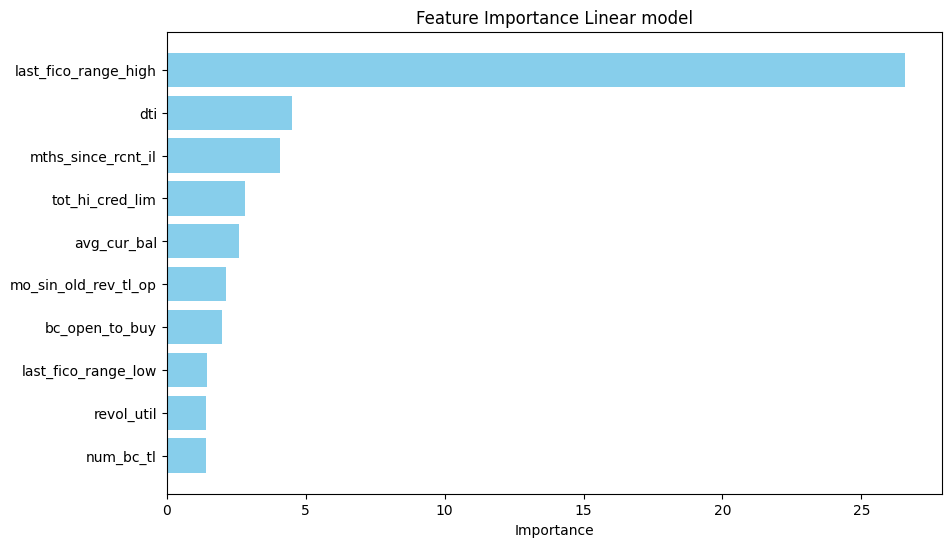

In [5]:
"""import matplotlib.pyplot as plt

features = ["last_fico_range_high","dti","mths_since_rcnt_il","tot_hi_cred_lim","avg_cur_bal","mo_sin_old_rev_tl_op","bc_open_to_buy","last_fico_range_low","revol_util","num_bc_tl"]
importance_scores = [26.563431,4.523994,4.070646,2.811177,2.585376,2.146228,1.985553,1.438794,1.431192,1.429582]

# Sort features by importance for better visualization
sorted_indices = sorted(range(len(importance_scores)), key=lambda i: importance_scores[i], reverse=True)
sorted_features = [features[i] for i in sorted_indices]
sorted_importance_scores = [importance_scores[i] for i in sorted_indices]

plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importance_scores, color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance Linear model')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()
"""